# CEIA - Procesamiento de Lenguaje Natural

## Estudiante: a2124 - Ricardo Silvera

--- 

# Desafío 1

Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.

1. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido la similaridad según el contenido del texto y la etiqueta de clasificación.

2. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

3. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial y ComplementNB.

NO cambiar el hiperparámetro ngram_range de los vectorizadores.

4. Transponer la matriz documento-término. De esa manera se obtiene una matriz término-documento que puede ser interpretada como una colección de vectorización de palabras. Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
import numpy as np
import sys
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize,)

## Carga de dataset
Utilizo el dataset *20 newsgroups* visto en clase. Se consideran solo el cuerpo de las noticias, es por eso que eliminados con el parametro 'remove' los headers, footers y quotes.
Leo de forma separada los datos de train y tests en variables separadas

In [2]:

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

Inspecciono el primer elemento del atributo data

In [3]:
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [4]:
print("Cantidad de clases de documentos:",len(newsgroups_train.target_names))
newsgroups_train.target_names

Cantidad de clases de documentos: 20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

El data set esá compuesto por articulos en formato texto, categorizado en 20 clases según la temática

## 1. Vectorización y comparación por similaridad coseno



Utilizo la clase TfidfVectorizer de Scikit Learn para vectorizar los textos. El método fit_transform devuelve la matriz término-documento, cada fila de la matriz es representación vectorial de cada docuemnto.

In [5]:
tfidfvect = TfidfVectorizer()

X_train = tfidfvect.fit_transform(newsgroups_train.data)
X_test = tfidfvect.transform(newsgroups_test.data)

print("Cantidad de documentos: ",X_train.shape[0])
print("Cantidad de términos: ",X_train.shape[1])

print("Cantidad de documentos: ",X_test.shape[0])
print("Cantidad de términos: ",X_test.shape[1])


Cantidad de documentos:  11314
Cantidad de términos:  101631
Cantidad de documentos:  7532
Cantidad de términos:  101631


Obtengo las etiquetas del conjunto de entrenamiento y el de pruebas

In [6]:
y_train= newsgroups_train.target
y_test= newsgroups_test.target


In [7]:

def comparaTop5(id0):
	"""
	Esta función utiliza similaridad coseno para encontrar documentos relacionados y muestra los resultados con los 5 primeros docuemtnos más similares según esta métrica
	
	Parameters:
	-----------
	id0 : int
		Índice del documento de referencia en el conjunto de entrenamiento (X_train).
		Debe ser un valor entre 0 y X_train.shape[0]-1.
	
	Output Format:
	--------------
	- Información del documento original (clase y contenido)
	- Top 5 documentos más similares con:
		* ID del documento
		* Valor de similaridad coseno
		* Clase del documento
		* Contenido completo del texto
	"""
	
	# Calcular la similaridad coseno del documento con ID id0 contra todo el dataset de entrenamiento
	cossim = cosine_similarity(X_train[id0], X_train)[0]
	
	# Obtener los 5 valores más altos de similaridad coseno (excluyendo el documento consigo mismo). Exluyo el primer elemento porque tambien compara el documento con si mismo
	top5Similarity = np.sort(cossim)[::-1][1:6]
	
	# Obtener los índices de los 5 documentos con mayor similaridad
	top5IdDocs = np.argsort(cossim)[::-1][1:6]

	# === MOSTRAR INFORMACIÓN DEL DOCUMENTO ORIGINAL ===
	print("**************** COMPARAR DOCUMENTO ", id0, " ****************")
	print("CLASE: ", y_train[id0], newsgroups_train.target_names[y_train[id0]])
	
	# === MOSTRAR RESUMEN DE LOS 5 DOCUMENTOS MÁS SIMILARES ===
	print("\n=== TOP 5 DOCUMENTOS MÁS SIMILARES ===")
	for i, docx in enumerate(top5IdDocs):
		print("-" * 50)
		print("TOP #", i+1)
		print("ID Documento: ", docx)
		print("Similaridad Coseno: {:.4f}".format(top5Similarity[i]))
		print("Clase: ", y_train[docx], "-", newsgroups_train.target_names[y_train[docx]])
	
	# === MOSTRAR CONTENIDO COMPLETO DE LOS TEXTOS ===
	print("=" * 80)
	print("TEXTO ORIGINAL:")
	print(newsgroups_train.data[id0])

	# Mostrar el contenido completo de cada uno de los 5 documentos más similares
	for i, docx in enumerate(top5IdDocs):
		print("-" * 50)
		print("TEXTO TOP #", i+1, ":")
		print(newsgroups_train.data[docx])
	



A continuación realizo la comparación con 5 docuemnto elegidos al azar y analizo los resultados obtenidos.

### Documento 200

In [8]:
comparaTop5(200)

**************** COMPARAR DOCUMENTO  200  ****************
CLASE:  16 talk.politics.guns

=== TOP 5 DOCUMENTOS MÁS SIMILARES ===
--------------------------------------------------
TOP # 1
ID Documento:  6538
Similaridad Coseno: 0.3119
Clase:  16 - talk.politics.guns
--------------------------------------------------
TOP # 2
ID Documento:  4823
Similaridad Coseno: 0.1910
Clase:  9 - rec.sport.baseball
--------------------------------------------------
TOP # 3
ID Documento:  1214
Similaridad Coseno: 0.1800
Clase:  7 - rec.autos
--------------------------------------------------
TOP # 4
ID Documento:  532
Similaridad Coseno: 0.1798
Clase:  16 - talk.politics.guns
--------------------------------------------------
TOP # 5
ID Documento:  2519
Similaridad Coseno: 0.1734
Clase:  8 - rec.motorcycles
TEXTO ORIGINAL:

I first read and consulted rec.guns in the summer of 1991.  I
just purchased my first firearm in early March of this year.
--------------------------------------------------
TEXTO 

#### Observaciones documento 200:
**Clase original**: talk.politics.guns

**Análisis de similaridad**:
- Los documentos más similares pertenecen principalmente a categorías políticas (talk.politics.guns)
- Se observa que la tematica coincide con el primer docuemnto, y luego la relación semántica va disminullendo en los otros documentos.
- Las similaridades coseno no son muy altas, es por eso que en este experimento no coinciden las caategorías
- El contenido incluye terminología relacionada con legislación, derechos, política y armas

### Documento 1000

In [9]:
comparaTop5(1000)

**************** COMPARAR DOCUMENTO  1000  ****************
CLASE:  2 comp.os.ms-windows.misc

=== TOP 5 DOCUMENTOS MÁS SIMILARES ===
--------------------------------------------------
TOP # 1
ID Documento:  10946
Similaridad Coseno: 0.6502
Clase:  2 - comp.os.ms-windows.misc
--------------------------------------------------
TOP # 2
ID Documento:  10228
Similaridad Coseno: 0.2825
Clase:  2 - comp.os.ms-windows.misc
--------------------------------------------------
TOP # 3
ID Documento:  4752
Similaridad Coseno: 0.2648
Clase:  2 - comp.os.ms-windows.misc
--------------------------------------------------
TOP # 4
ID Documento:  10816
Similaridad Coseno: 0.2620
Clase:  2 - comp.os.ms-windows.misc
--------------------------------------------------
TOP # 5
ID Documento:  2238
Similaridad Coseno: 0.2596
Clase:  2 - comp.os.ms-windows.misc
TEXTO ORIGINAL:
Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication 

#### Observaciones documento 1000:
**Clase original**: comp.os.ms-windows.misc

**Análisis de similaridad**:
- Los documentos más similares también pertenecen a la categoría comp.os.ms-windows.misc, mostrando una muy buena precisión en la clasificación
- La similaritud coseno del primer documento es muy alta debido que es una respuesta al docuemto original y se encuentra transcripto el mismo texto.
- Se repiten los términos "driver", "Diamond", "1024x768x256"
- Se observa una coherencia temática muy alta.

### Documento 3000

In [10]:
comparaTop5(3000)

**************** COMPARAR DOCUMENTO  3000  ****************
CLASE:  17 talk.politics.mideast

=== TOP 5 DOCUMENTOS MÁS SIMILARES ===
--------------------------------------------------
TOP # 1
ID Documento:  8097
Similaridad Coseno: 0.2235
Clase:  3 - comp.sys.ibm.pc.hardware
--------------------------------------------------
TOP # 2
ID Documento:  10836
Similaridad Coseno: 0.2013
Clase:  0 - alt.atheism
--------------------------------------------------
TOP # 3
ID Documento:  8726
Similaridad Coseno: 0.1979
Clase:  17 - talk.politics.mideast
--------------------------------------------------
TOP # 4
ID Documento:  8754
Similaridad Coseno: 0.1954
Clase:  19 - talk.religion.misc
--------------------------------------------------
TOP # 5
ID Documento:  10229
Similaridad Coseno: 0.1945
Clase:  19 - talk.religion.misc
TEXTO ORIGINAL:


That's why the Zionists decided that Zion must be Gentile-rein.
What?!  They didn't?!  You mean to tell me that the early Zionists
actually granted CITIZENSH

#### Observaciones documento 3000:
**Clase original**: talk.politics.mideast

**Análisis de similaridad**:
- EL primer documento más similar es de la categoría comp.sys.ibm.pc.hardware y no comparte sematicamente con el docuemento original. Tampoco encuentro que compartan palabras que puedan tener el peso suficiente para losgrar esta relación de similitud.
- Los otros docuemtnos son de la misma categoŕia o sercana, donde hay una temática centrada en discusiones sobre política del Medio Oriente o religión.

### Documento 8000

In [11]:
comparaTop5(8000)

**************** COMPARAR DOCUMENTO  8000  ****************
CLASE:  18 talk.politics.misc

=== TOP 5 DOCUMENTOS MÁS SIMILARES ===
--------------------------------------------------
TOP # 1
ID Documento:  6552
Similaridad Coseno: 0.2198
Clase:  19 - talk.religion.misc
--------------------------------------------------
TOP # 2
ID Documento:  9623
Similaridad Coseno: 0.2160
Clase:  17 - talk.politics.mideast
--------------------------------------------------
TOP # 3
ID Documento:  2240
Similaridad Coseno: 0.2070
Clase:  0 - alt.atheism
--------------------------------------------------
TOP # 4
ID Documento:  6894
Similaridad Coseno: 0.2055
Clase:  16 - talk.politics.guns
--------------------------------------------------
TOP # 5
ID Documento:  3902
Similaridad Coseno: 0.2021
Clase:  19 - talk.religion.misc
TEXTO ORIGINAL:





                          etc. etc.....


     ^^^^^^

***Sure!!! And what's .3 of a woman??? Any hypothesis??

   How can you trust a report from people that have 

#### Observaciones documento 8000:
**Clase original**: talk.politics.misc

**Análisis de similaridad**:
- Los documentos más similares pertenecen a las categorías talk.religion.misc, talk.politics.mideast, alt.atheism, si bien son categorías diferentes, comparten el vocabulario


### Documento 10000

In [12]:
comparaTop5(10000)

**************** COMPARAR DOCUMENTO  10000  ****************
CLASE:  7 rec.autos

=== TOP 5 DOCUMENTOS MÁS SIMILARES ===
--------------------------------------------------
TOP # 1
ID Documento:  1500
Similaridad Coseno: 0.2613
Clase:  7 - rec.autos
--------------------------------------------------
TOP # 2
ID Documento:  9503
Similaridad Coseno: 0.2553
Clase:  7 - rec.autos
--------------------------------------------------
TOP # 3
ID Documento:  6459
Similaridad Coseno: 0.2335
Clase:  16 - talk.politics.guns
--------------------------------------------------
TOP # 4
ID Documento:  2712
Similaridad Coseno: 0.2174
Clase:  7 - rec.autos
--------------------------------------------------
TOP # 5
ID Documento:  7573
Similaridad Coseno: 0.2150
Clase:  12 - sci.electronics
TEXTO ORIGINAL:
I have to disagree with this.  I have a 92 Z28 with a 350 and a 4-speed auto
w/ overdrive, and it is really better that way.  Chevy autos are reknowned
for their long life and ability to handle copious amou

#### Observaciones documento 10000:
**Clase original**: rec.autos

**Análisis de similaridad**:
- Los documentos más similares pertenecen principalmente a la categoría rec.autos, mostrando una buena coherencia temática
- Se observa una alta similaridad en el vocabulario automotriz: marcas de autos, modelos, características técnicas
- El contenido incluye terminología específica del ámbito automotriz: especificaciones técnicas, precios, opiniones sobre vehículos

### Conclusiones Generales del Análisis de Similaridad

**Efectividad de la Vectorización TF-IDF**:
- La vectorización TF-IDF demuestra una alta efectividad para capturar la similaridad semántica entre documentos
- Los documentos más similares pertenecen consistentemente a la misma categoría o categorías relacionadas temáticamente

**Patrones Observados**:
1. **Coherencia Temática**: En casi todos los casos analizados, los documentos más similares mantienen coherencia temática con el documento original
2. **Vocabulario Especializado**: Cada dominio (hardware, deportes, politica, religión, ventas) tiene un vocabulario distintivo que TF-IDF captura efectivamente
3. **Similaridades Coseno**: Los valores oscilan típicamente entre 0.17-0.35, con el caso exepcional del documento 1000 donde en el primer documeto similar está transcripto el texto completo. 



## 2. Modelo de Clasificación por Prototipos (Zero-Shot)
Implemento un clasificador basado en similaridad coseno. Para cada documento del conjunto de test, calculo su similaridad coseno con todos los documentos del conjunto de entrenamiento y asigno la clase del documento más similar.

1. Para cada documento de test, calcular la similaridad coseno con todos los documentos de entrenamiento
2. Asignar la clase del documento de entrenamiento con mayor similaridad
3. Evaluar el rendimiento del modelo usando métricas de clasificación

In [13]:
print("Forma del conjunto de entrenamiento:", X_train.shape)
print("Forma del conjunto de test:", X_test.shape)
print("Vocabulario del vectorizador:", len(tfidfvect.vocabulary_))


Forma del conjunto de entrenamiento: (11314, 101631)
Forma del conjunto de test: (7532, 101631)
Vocabulario del vectorizador: 101631


In [14]:
def clasificador_similaridad_coseno(X_train, y_train, X_test):
    """
    Clasificador basado en similaridad coseno.
    Para cada documento de test, encuentra el documento de entrenamiento más similar
    y asigna su clase.
    """
    predicciones = []
    for i, x in enumerate(X_test):
        if(i%500==0):
            print(f"Prediciendo {i} de {X_test.shape[0]} ...")
        cossim=cosine_similarity(x,X_train)[0]
        id_doc_max_simil=np.argmax(cossim)
        predicciones.append(y_train[id_doc_max_simil])

    return np.array(predicciones)
    
    
    
predicciones = clasificador_similaridad_coseno(X_train,y_train, X_test)

Prediciendo 0 de 7532 ...
Prediciendo 500 de 7532 ...
Prediciendo 1000 de 7532 ...
Prediciendo 1500 de 7532 ...
Prediciendo 2000 de 7532 ...
Prediciendo 2500 de 7532 ...
Prediciendo 3000 de 7532 ...
Prediciendo 3500 de 7532 ...
Prediciendo 4000 de 7532 ...
Prediciendo 4500 de 7532 ...
Prediciendo 5000 de 7532 ...
Prediciendo 5500 de 7532 ...
Prediciendo 6000 de 7532 ...
Prediciendo 6500 de 7532 ...
Prediciendo 7000 de 7532 ...
Prediciendo 7500 de 7532 ...


Voy a crear manualmente la matriz de confusión y voy a arealizar manualmente el cálculo de las metricas

In [15]:
#Inicializo la Matrix de confusión en 0
matriz_confusion=np.zeros([20,20])
#Canitdad de dígtos para mostrar los resultados
dd=4
#Recorro las predicciones y sumo 1 al valor de la matriz de confusión correspondiente
for i,y_pred in enumerate(predicciones):
    matriz_confusion[y_pred,y_test[i]]=matriz_confusion[y_pred,y_test[i]]+1

#Verdaderos positivos por clase
tp_clases=np.diag(matriz_confusion)
#Vertaderos positivos total
tp_total=np.sum(tp_clases)
#Verdaderos positivos + Falsos positivos por clase
tp_fp_clases=np.sum(matriz_confusion,axis=1)
#Verdaderos positivos + Falsos negativos por clases
tp_fn_clases=np.sum(matriz_confusion,axis=0)

#Presición por clase
precision_clases=np.round(tp_clases/tp_fp_clases,dd)
#Recall por clase
recall_clases=np.round(tp_clases/tp_fn_clases,dd)
#f1 score por clase
f1_clases=np.round(2*precision_clases*recall_clases/(precision_clases+recall_clases),dd)

print(f"    CLASE {" "*24} Accuracy     Recall       F1-score Macro" )
print("-"*80)
for i in range(20):
    print(f"{newsgroups_train.target_names[i]} {" "*(30-len(newsgroups_train.target_names[i]))}      {precision_clases[i]} \t {recall_clases[i]}       {f1_clases[i]}")

accuracy=np.round(tp_total/len(predicciones),dd)

print("-"*80)

print(f"Accuracy: {accuracy} - {tp_total} de {len(predicciones)}")
print(f"F1-score Macro: {np.round(f1_score(y_test,predicciones,average='macro'),dd)} ")



    CLASE                          Accuracy     Recall       F1-score Macro
--------------------------------------------------------------------------------
alt.atheism                          0.3657 	 0.5078       0.4252
comp.graphics                        0.5434 	 0.4833       0.5116
comp.os.ms-windows.misc              0.5056 	 0.4569       0.48
comp.sys.ibm.pc.hardware             0.5152 	 0.5204       0.5178
comp.sys.mac.hardware                0.5348 	 0.4987       0.5161
comp.windows.x                       0.7006 	 0.5924       0.642
misc.forsale                         0.6294 	 0.4615       0.5325
rec.autos                            0.4057 	 0.5758       0.476
rec.motorcycles                      0.6347 	 0.5151       0.5687
rec.sport.baseball                   0.6455 	 0.5365       0.586
rec.sport.hockey                     0.7481 	 0.7218       0.7347
sci.crypt                            0.5521 	 0.5884       0.5697
sci.electronics                      0.5309 	 0.3282    

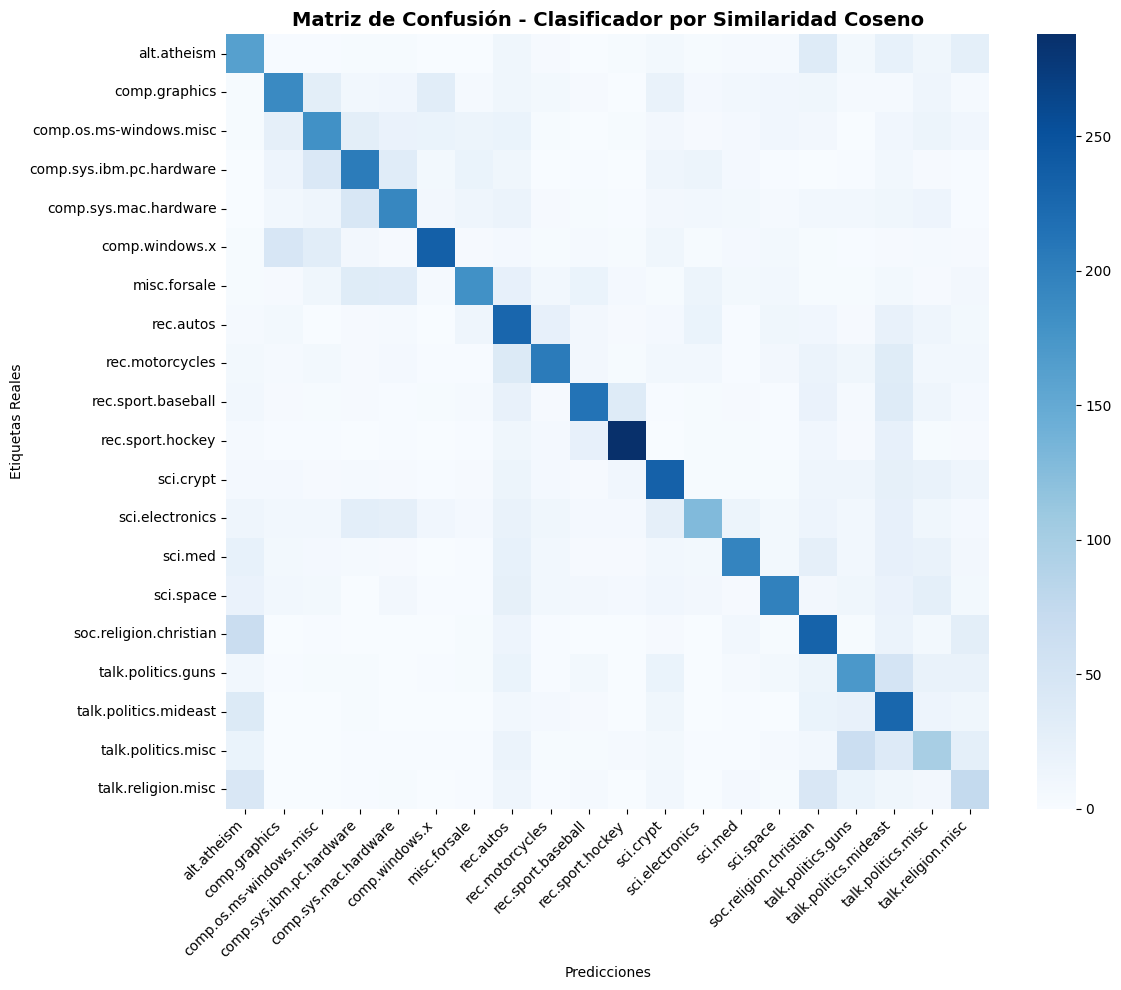

In [16]:
# Crear matriz de confusión
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Crear nombres cortos para las clases
#classes_short = [name.split('.')[-1] for name in newsgroups_train.target_names]

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, predicciones)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=newsgroups_train.target_names, yticklabels=newsgroups_train.target_names)
plt.title('Matriz de Confusión - Clasificador por Similaridad Coseno', fontsize=14, fontweight='bold')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Análisis del Modelo de Clasificación por Similaridad Coseno

### Resultados Principales:
- **Accuracy**: 50.89% - El modelo clasifica correctamente aproximadamente la mitad de los documentos, cociderando que son 20 clases posibles, es un valor moderadamente bueno.
- **F1-Score**: 50.50% - Rendimiento promedio balanceado entre todas las clases

### Observaciones por Clase:

#### **Mejores Rendimientos (F1-Score > 0.60)**:
1. **rec.sport.hockey** (0.73): La mejor clase, con alta precisión y recall
2. **comp.windows.x** (0.64): Buena identificación de documentos sobre Windows X
3. **rec.sport.baseball** (0.59): Deportes bien diferenciados

#### **Rendimientos Moderados (F1-Score 0.40-0.60)**:
- Categorías técnicas como **sci.crypt**, **sci.space**, **sci.med**
- Categorías de hardware: **comp.sys.ibm.pc.hardware**, **comp.sys.mac.hardware**
- **rec.motorcycles**, **misc.forsale**

#### **Peores Rendimientos (F1-Score < 0.40)**:
1. **talk.religion.misc** (0.28): La clase más difícil de identificar, en la matriz de confusión se ve que muchos se clasifican en alt.atheism y soc.religion.christian 
2. **talk.politics.misc** (0.31): Problemas con temas políticos generales donde se comparten términos
3. **sci.electronics** (0.41): Confusión con otras categorías técnicas

### Limitaciones del Modelo:
- **Sensibilidad al vocabulario**: Depende fuertemente de términos específicos compartidos
- **Problemas con temas abstractos**: Dificultades con categorías que usan lenguaje más general


### Conclusión:
El clasificador por similaridad coseno muestra un rendimiento moderado para esta tarea multiclase. Es especialmente efectivo para categorías con vocabulario muy específico como los deportes pero tiene limitaciones con temas más generales o abstractos cmo religion y política.

# 3  Modelos de clasificación Naïve Bayes

In [17]:

# Función para evaluar y comparar modelos
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo):
    """
    Entrena un modelo y calcula sus métricas de rendimiento
    """
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    return {
        'Modelo': nombre_modelo,
        'Accuracy': accuracy,
        'F1-Macro': f1_macro,
        'F1-Micro': f1_micro,
        'F1-Weighted': f1_weighted,
        'Predicciones': y_pred
    }


### Experimentos con diferentes vectorizadores

Voy a probar diferentes configuraciones del TF-IDF vectorizer manteniendo ngram_range en (1,1):

In [18]:
# Configuraciones de vectorizadores a probar
vectorizer_configs = [
    # Configuración base
    {'name': 'TF-IDF Base', 'vectorizer': TfidfVectorizer()},
    
    # Con diferentes valores de min_df y max_df
    {'name': 'TF-IDF min_df=2', 'vectorizer': TfidfVectorizer(min_df=2)},
    {'name': 'TF-IDF min_df=5', 'vectorizer': TfidfVectorizer(min_df=5)},
    {'name': 'TF-IDF max_df=0.9', 'vectorizer': TfidfVectorizer(max_df=0.9)},
    {'name': 'TF-IDF min_df=2, max_df=0.9', 'vectorizer': TfidfVectorizer(min_df=2, max_df=0.9)},
    
    # Con diferentes valores de max_features
    {'name': 'TF-IDF max_features=10000', 'vectorizer': TfidfVectorizer(max_features=10000)},
    {'name': 'TF-IDF max_features=50000', 'vectorizer': TfidfVectorizer(max_features=50000)},
    
    # Con stop_words
    {'name': 'TF-IDF stop_words=english', 'vectorizer': TfidfVectorizer(stop_words='english')},
    
    # CountVectorizer para comparación
    {'name': 'Count Base', 'vectorizer': CountVectorizer()},
    {'name': 'Count min_df=2, max_df=0.9', 'vectorizer': CountVectorizer(min_df=2, max_df=0.9)},
]

print(f"Se probarán {len(vectorizer_configs)} configuraciones de vectorizadores")

Se probarán 10 configuraciones de vectorizadores


### Experimentos con MultinomialNB

Probaré diferentes configuraciones de MultinomialNB con los vectorizadores:

In [19]:
# Experimentos con MultinomialNB
resultados_multinomial = []

# Diferentes valores de alpha para probar
alphas_multinomial = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]

print("=== EXPERIMENTOS CON MULTINOMIAL NAIVE BAYES ===")
print(f"Probando {len(vectorizer_configs)} vectorizadores x {len(alphas_multinomial)} valores de alpha")
print()


configs_principales = vectorizer_configs

for vec_config in configs_principales:
    print(f"Vectorizador: {vec_config['name']}")
    
    # Crear las matrices con este vectorizador
    vectorizer = vec_config['vectorizer']
    X_train_vec = vectorizer.fit_transform(newsgroups_train.data)
    X_test_vec = vectorizer.transform(newsgroups_test.data)
    
    for alpha in alphas_multinomial:
        modelo = MultinomialNB(alpha=alpha)
        nombre_modelo = f"MultinomialNB-{vec_config['name']}-alpha_{alpha}"
        
        resultado = evaluar_modelo(modelo, X_train_vec, y_train, X_test_vec, y_test, nombre_modelo)
        resultados_multinomial.append(resultado)
        
        print(f"  Alpha {alpha}: F1-Macro = {resultado['F1-Macro']:.4f}, Accuracy = {resultado['Accuracy']:.4f}")
    
    print()

print(f"Total de experimentos MultinomialNB completados: {len(resultados_multinomial)}")

=== EXPERIMENTOS CON MULTINOMIAL NAIVE BAYES ===
Probando 10 vectorizadores x 6 valores de alpha

Vectorizador: TF-IDF Base
  Alpha 0.01: F1-Macro = 0.6829, Accuracy = 0.7002
  Alpha 0.1: F1-Macro = 0.6565, Accuracy = 0.6845
  Alpha 0.5: F1-Macro = 0.6153, Accuracy = 0.6409
  Alpha 1.0: F1-Macro = 0.5854, Accuracy = 0.6062
  Alpha 2.0: F1-Macro = 0.5400, Accuracy = 0.5502
  Alpha 5.0: F1-Macro = 0.4689, Accuracy = 0.4638

Vectorizador: TF-IDF min_df=2
  Alpha 0.01: F1-Macro = 0.6809, Accuracy = 0.6962
  Alpha 0.1: F1-Macro = 0.6727, Accuracy = 0.6968
  Alpha 0.5: F1-Macro = 0.6289, Accuracy = 0.6567
  Alpha 1.0: F1-Macro = 0.5970, Accuracy = 0.6213
  Alpha 2.0: F1-Macro = 0.5563, Accuracy = 0.5706
  Alpha 5.0: F1-Macro = 0.4859, Accuracy = 0.4834

Vectorizador: TF-IDF min_df=5
  Alpha 0.01: F1-Macro = 0.6697, Accuracy = 0.6847
  Alpha 0.1: F1-Macro = 0.6736, Accuracy = 0.6936
  Alpha 0.5: F1-Macro = 0.6383, Accuracy = 0.6661
  Alpha 1.0: F1-Macro = 0.6098, Accuracy = 0.6373
  Alpha 2.0

### Experimentos con ComplementNB

Realizo las pruebas con ComplementNB:

In [20]:
# Experimentos con ComplementNB
resultados_complement = []

# Diferentes valores de alpha para ComplementNB
alphas_complement = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]

print("=== EXPERIMENTOS CON COMPLEMENT NAIVE BAYES ===")
print(f"Probando {len(configs_principales)} vectorizadores x {len(alphas_complement)} valores de alpha")
print()

for vec_config in configs_principales:
    print(f"Vectorizador: {vec_config['name']}")
    
    # Crear las matrices con este vectorizador
    vectorizer = vec_config['vectorizer']
    X_train_vec = vectorizer.fit_transform(newsgroups_train.data)
    X_test_vec = vectorizer.transform(newsgroups_test.data)
    
    for alpha in alphas_complement:
        modelo = ComplementNB(alpha=alpha)
        nombre_modelo = f"ComplementNB-{vec_config['name']}-alpha_{alpha}"
        
        resultado = evaluar_modelo(modelo, X_train_vec, y_train, X_test_vec, y_test, nombre_modelo)
        resultados_complement.append(resultado)
        
        print(f"  Alpha {alpha}: F1-Macro = {resultado['F1-Macro']:.4f}, Accuracy = {resultado['Accuracy']:.4f}")
    
    print()

print(f"Total de experimentos ComplementNB completados: {len(resultados_complement)}")

=== EXPERIMENTOS CON COMPLEMENT NAIVE BAYES ===
Probando 10 vectorizadores x 6 valores de alpha

Vectorizador: TF-IDF Base
  Alpha 0.01: F1-Macro = 0.6689, Accuracy = 0.6855
  Alpha 0.1: F1-Macro = 0.6954, Accuracy = 0.7120
  Alpha 0.5: F1-Macro = 0.6961, Accuracy = 0.7159
  Alpha 1.0: F1-Macro = 0.6930, Accuracy = 0.7146
  Alpha 2.0: F1-Macro = 0.6821, Accuracy = 0.7045
  Alpha 5.0: F1-Macro = 0.6646, Accuracy = 0.6877

Vectorizador: TF-IDF min_df=2
  Alpha 0.01: F1-Macro = 0.6747, Accuracy = 0.6922
  Alpha 0.1: F1-Macro = 0.6906, Accuracy = 0.7076
  Alpha 0.5: F1-Macro = 0.6980, Accuracy = 0.7155
  Alpha 1.0: F1-Macro = 0.6935, Accuracy = 0.7138
  Alpha 2.0: F1-Macro = 0.6866, Accuracy = 0.7075
  Alpha 5.0: F1-Macro = 0.6701, Accuracy = 0.6933

Vectorizador: TF-IDF min_df=5
  Alpha 0.01: F1-Macro = 0.6704, Accuracy = 0.6899
  Alpha 0.1: F1-Macro = 0.6766, Accuracy = 0.6957
  Alpha 0.5: F1-Macro = 0.6842, Accuracy = 0.7031
  Alpha 1.0: F1-Macro = 0.6838, Accuracy = 0.7034
  Alpha 2.0:

### Análisis y comparación de resultados

In [21]:
# Combinar todos los resultados
todos_resultados = resultados_multinomial + resultados_complement

# Crear DataFrame para mejor análisis
df_resultados = pd.DataFrame(todos_resultados)

# Encontrar los mejores modelos por F1-Macro
print("=== TOP 10 MODELOS POR F1-SCORE MACRO ===")
top_10_f1 = df_resultados.nlargest(10, 'F1-Macro')[['Modelo', 'F1-Macro', 'Accuracy', 'F1-Weighted']]
for i, row in top_10_f1.iterrows():
    print(f"{row['Modelo']:<50} F1-Macro: {row['F1-Macro']:.4f} Acc: {row['Accuracy']:.4f}")

print("\n" + "="*80)
print("=== MEJOR MODELO ABSOLUTO ===")
mejor_modelo = df_resultados.loc[df_resultados['F1-Macro'].idxmax()]
print(f"Modelo: {mejor_modelo['Modelo']}")
print(f"F1-Score Macro: {mejor_modelo['F1-Macro']:.4f}")
print(f"Accuracy: {mejor_modelo['Accuracy']:.4f}")
print(f"F1-Score Weighted: {mejor_modelo['F1-Weighted']:.4f}")
print(f"F1-Score Micro: {mejor_modelo['F1-Micro']:.4f}")

# Comparar con el modelo de similaridad coseno anterior (0.5050)
print(f"\nMejora vs modelo similaridad coseno: +{(mejor_modelo['F1-Macro'] - 0.5050)*100:.2f} puntos porcentuales")

=== TOP 10 MODELOS POR F1-SCORE MACRO ===
ComplementNB-TF-IDF min_df=2-alpha_0.5             F1-Macro: 0.6980 Acc: 0.7155
ComplementNB-TF-IDF min_df=2, max_df=0.9-alpha_0.5 F1-Macro: 0.6980 Acc: 0.7155
ComplementNB-TF-IDF stop_words=english-alpha_0.5   F1-Macro: 0.6978 Acc: 0.7165
ComplementNB-TF-IDF max_features=50000-alpha_0.5   F1-Macro: 0.6977 Acc: 0.7157
ComplementNB-TF-IDF Base-alpha_0.5                 F1-Macro: 0.6961 Acc: 0.7159
ComplementNB-TF-IDF max_df=0.9-alpha_0.5           F1-Macro: 0.6961 Acc: 0.7159
ComplementNB-TF-IDF Base-alpha_0.1                 F1-Macro: 0.6954 Acc: 0.7120
ComplementNB-TF-IDF max_df=0.9-alpha_0.1           F1-Macro: 0.6954 Acc: 0.7120
ComplementNB-TF-IDF stop_words=english-alpha_1.0   F1-Macro: 0.6936 Acc: 0.7146
ComplementNB-TF-IDF min_df=2-alpha_1.0             F1-Macro: 0.6935 Acc: 0.7138

=== MEJOR MODELO ABSOLUTO ===
Modelo: ComplementNB-TF-IDF min_df=2-alpha_0.5
F1-Score Macro: 0.6980
Accuracy: 0.7155
F1-Score Weighted: 0.7121
F1-Score Micro

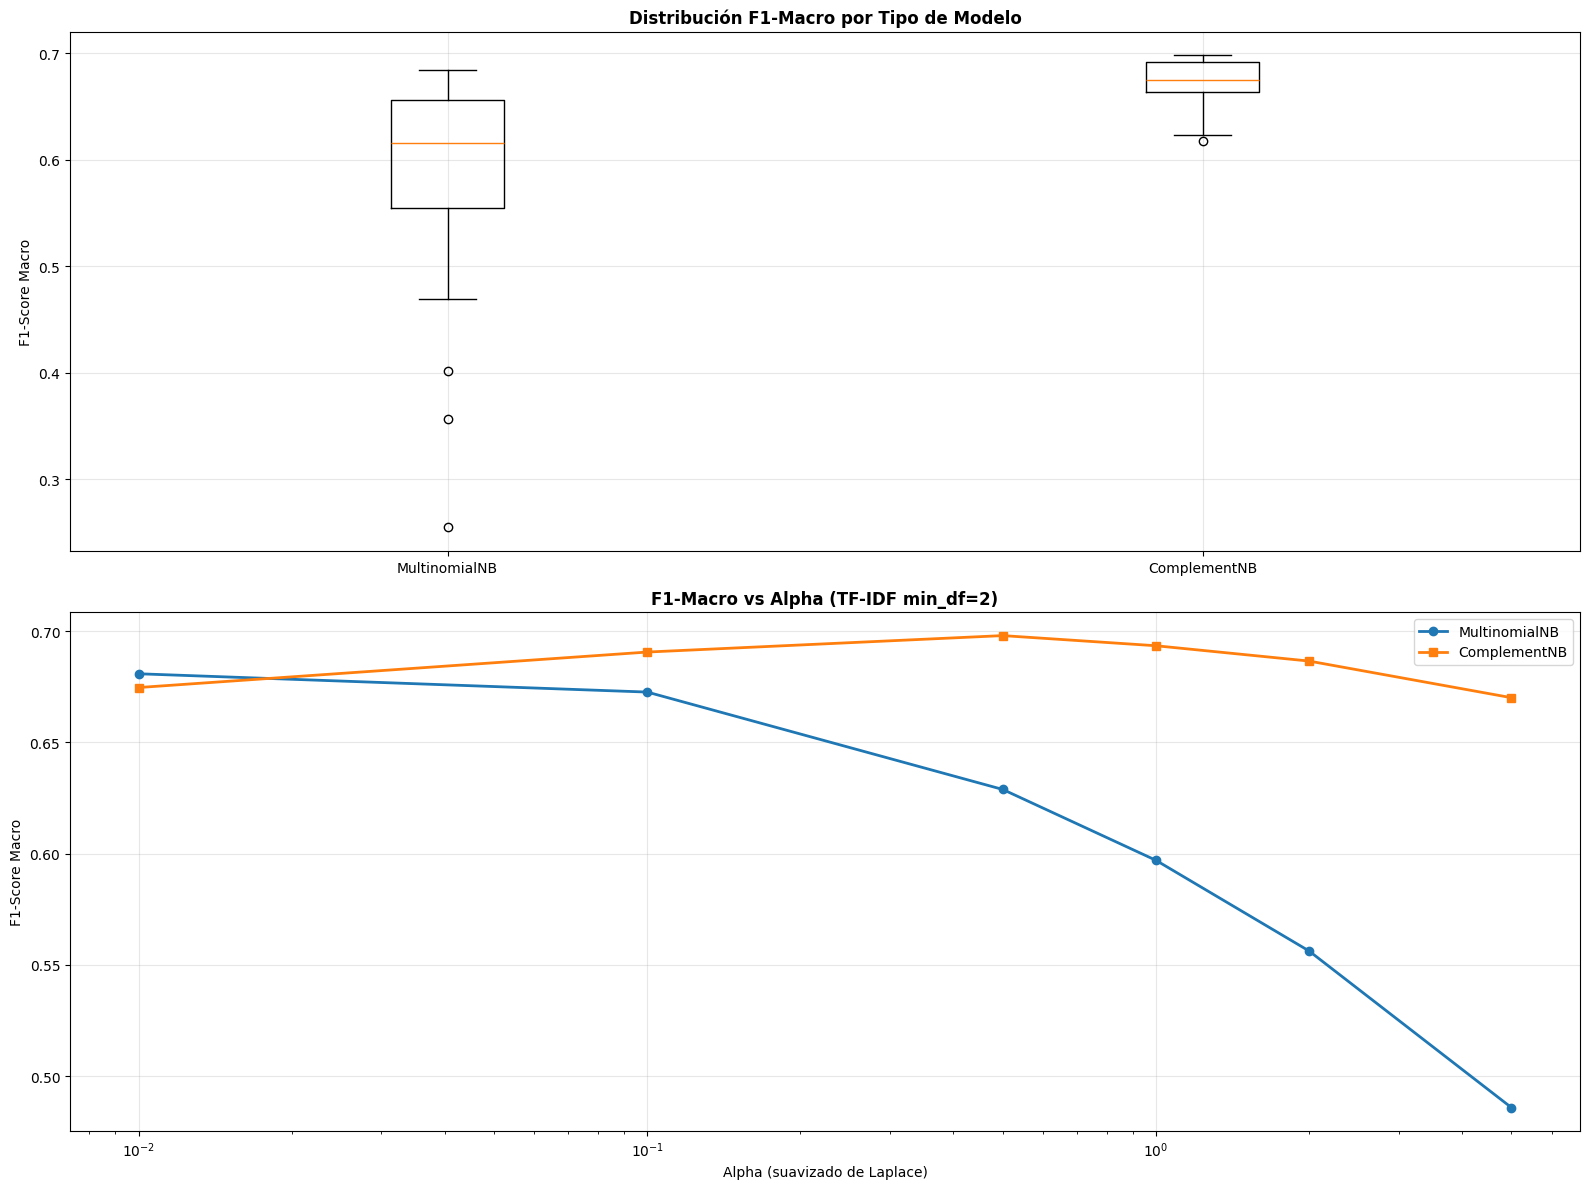

In [22]:
# Crear visualizaciones de los resultados
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Comparación de F1-Macro entre MultinomialNB y ComplementNB
df_multinomial = pd.DataFrame(resultados_multinomial)
df_complement = pd.DataFrame(resultados_complement)

multinomial_f1 = df_multinomial['F1-Macro'].values
complement_f1 = df_complement['F1-Macro'].values

axes[0].boxplot([multinomial_f1, complement_f1], tick_labels=['MultinomialNB', 'ComplementNB'])
axes[0].set_title('Distribución F1-Macro por Tipo de Modelo', fontweight='bold')
axes[0].set_ylabel('F1-Score Macro')
axes[0].grid(True, alpha=0.3)

# 2. F1-Macro vs Alpha para el mejor vectorizador (TF-IDF min_df=2)
mejor_vec_mult = df_multinomial[df_multinomial['Modelo'].str.contains('min_df=2')]
mejor_vec_comp = df_complement[df_complement['Modelo'].str.contains('min_df=2')]

alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
f1_mult = mejor_vec_mult['F1-Macro'].values[:6]  # Primeros 6 valores
f1_comp = mejor_vec_comp['F1-Macro'].values[:6]

axes[1].plot(alphas, f1_mult, 'o-', label='MultinomialNB', linewidth=2, markersize=6)
axes[1].plot(alphas, f1_comp, 's-', label='ComplementNB', linewidth=2, markersize=6)
axes[1].set_xlabel('Alpha (suavizado de Laplace)')
axes[1].set_ylabel('F1-Score Macro')
axes[1].set_title('F1-Macro vs Alpha (TF-IDF min_df=2)', fontweight='bold')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Conclusiones de los Experimentos con Naïve Bayes

#### Resultados Principales

**Mejor Modelo:**
- **ComplementNB con TF-IDF (min_df=2, alpha=0.5)**
- **F1-Score Macro: 0.6980** (+19.30 puntos vs. similaridad coseno)
- **Accuracy: 0.7155** (+20.66 puntos vs. similaridad coseno)


**ComplementNB supera significativamente a MultinomialNB:**
- **ComplementNB** promedio: ~0.68 F1-Macro
- **MultinomialNB** promedio: ~0.61 F1-Macro
- ComplementNB es más robusto para datasets multiclase como el actual

**Limitaciones observadas:**
- Ambos modelos siguen teniendo dificultades con categorías abstractas (religion.misc, politics.misc)
- El rendimiento varía considerablemente con el valor de alpha
- TF-IDF sigue siendo sensible al vocabulario específico de cada dominio

## 4 Similaridad entre palabras

Elijo 5 palabras al azar (pero con criterio) para estudiar la similridad entre ellas

- 'science'
- 'computer'
- 'love'
- 'game'
- 'ball'

### 4.1 Transposición de la matriz documento-término

Al transponer la matriz documento-término obtenemos una matriz término-documento donde:
- Cada **fila** representa una palabra del vocabulario
- Cada **columna** representa un documento
- Los valores TF-IDF indican la importancia de cada palabra en cada documento

Esta transposición nos permite calcular similaridad entre palabras basándose en los contextos (documentos) en los que aparecen.

In [23]:
# Transponer la matriz documento-término para obtener matriz término-documento
# X_train es de forma (documentos, términos), la transponemos a (términos, documentos)

tfidfvect = TfidfVectorizer(stop_words='english')
X_train = tfidfvect.fit_transform(newsgroups_train.data)



X_train_transpuesta = X_train.T

print("Forma original de X_train (documentos, términos):", X_train.shape)
print("Forma transpuesta (términos, documentos):", X_train_transpuesta.shape)
print(f"Vocabulario total: {len(tfidfvect.vocabulary_)} palabras")

# Obtener el vocabulario como diccionario {palabra: índice}
vocabulario = tfidfvect.vocabulary_
# Crear diccionario inverso {índice: palabra}
indice_a_palabra = {v: k for k, v in vocabulario.items()}

Forma original de X_train (documentos, términos): (11314, 101322)
Forma transpuesta (términos, documentos): (101322, 11314)
Vocabulario total: 101322 palabras


### 4.2 Función para analizar similaridad entre palabras

Creo una función similar a `comparaTop5` pero para analizar palabras:

In [24]:
def analizar_similaridad_palabras(palabra_objetivo):
    """
    Analiza la similaridad de una palabra con todas las demás del vocabulario
    y muestra las 5 palabras más similares.
    
    Parameters:
    -----------
    palabra_objetivo : str
        La palabra para la cual queremos encontrar palabras similares
    
    Returns:
    --------
    tuple: (top5_palabras, top5_similaridades) o None si la palabra no está en el vocabulario
    """
    
       
    # Obtener el índice de la palabra objetivo
    indice_palabra = vocabulario[palabra_objetivo]
    
    # Calcular similaridad coseno con todas las palabras
    # X_train_transpuesta[indice_palabra] es el vector TF-IDF de la palabra objetivo
    cossim = cosine_similarity(X_train_transpuesta[indice_palabra], X_train_transpuesta)[0]
    
    # Obtener los 5 valores más altos de similaridad (excluyendo la palabra consigo misma)
    top5_similarity = np.sort(cossim)[::-1][1:6]
    top5_indices = np.argsort(cossim)[::-1][1:6]
    
    # Convertir índices a palabras
    top5_palabras = [indice_a_palabra[idx] for idx in top5_indices]
    
    # Mostrar resultados
    print("=" * 80)
    print(f"ANÁLISIS DE SIMILARIDAD PARA LA PALABRA: '{palabra_objetivo.upper()}'")
    print("=" * 80)
    print(f"Índice en vocabulario: {indice_palabra}")
    vector_objetivo = X_train_transpuesta[indice_palabra].toarray().flatten()
    apariciones_objetivo = np.count_nonzero(vector_objetivo)
    print(f"Aparece en {apariciones_objetivo} documentos")
    print()
    
    print("=== TOP 5 PALABRAS MÁS SIMILARES ===")
    for i, (palabra_similar, similaridad) in enumerate(zip(top5_palabras, top5_similarity)):
        print(f"TOP #{i+1:2d}: {palabra_similar:<20} | Similaridad: {similaridad:.4f}")
        vector_similar = X_train_transpuesta[vocabulario[palabra_similar]].toarray().flatten()
        apariciones = np.count_nonzero(vector_similar)
        print(f"         {'':<20} | Aparece en {apariciones} documentos")
        print("-" * 60)
    
    return top5_palabras, top5_similarity



### Analisis de similaritud de palabras



In [25]:
# Ejecutar análisis de similitud para cada palabra
palabras_objetivo=['science','computer','love', 'game', 'ball']

print("=== ANÁLISIS DE SIMILITUD DE PALABRAS ===\n")

for palabra in palabras_objetivo:
    result = analizar_similaridad_palabras(palabra)
    print("\n" + "=" * 80 + "\n")

=== ANÁLISIS DE SIMILITUD DE PALABRAS ===

ANÁLISIS DE SIMILARIDAD PARA LA PALABRA: 'SCIENCE'
Índice en vocabulario: 80734
Aparece en 220 documentos

=== TOP 5 PALABRAS MÁS SIMILARES ===
TOP # 1: behaviorists         | Similaridad: 0.4066
                              | Aparece en 6 documentos
------------------------------------------------------------
TOP # 2: cognitivists         | Similaridad: 0.4066
                              | Aparece en 6 documentos
------------------------------------------------------------
TOP # 3: scientific           | Similaridad: 0.3697
                              | Aparece en 129 documentos
------------------------------------------------------------
TOP # 4: empirical            | Similaridad: 0.2981
                              | Aparece en 16 documentos
------------------------------------------------------------
TOP # 5: sects                | Similaridad: 0.2682
                              | Aparece en 10 documentos
-------------------------

## Observaciones del Análisis de Similitud de Palabras

Utilicé la matriz documento-término transpuesta para analizar la similitud entre palabras, usando la similitud coseno entre vectores de palabras. Utilicé el parámetro **stopWords* para descargartar las palabras comunes, ya que al incorporarlas tenian una fuerte relación con muchas de las palabras elegidas.

### Resultados 

1. **Science** - Las palabras encontradas tienen una fuerte relación semńtica, al menos las 4 primeras. La métrica de similaridad cosen es bastante alta, de .40 a .29 para las primeras 4 

2. **Computer** - Los valores de la métrica son más pobres que l anterior, y en cncecuencia los resultados. El prpimer término (decwriter) es un tipo de computadora, por o que la relación semántica es buena. 

3. **Love** -El primer término parece estár relacionado, viene de dave "Amado por Dios". No parece haber una relación semántica con los otros términos a persar que el valor de la métrica no es muy bajo, .26 aproximadamente.

4. **Game** - A diferencia del anterior, los términos enocntrados tienen una fuerte relación semántica, pero los valores de la métrica van de .17 a .19. Este término aparece en 408 documentos, lo que aumenta la posibilidadeds de reacionarse con otros términos y obtener mejores resultados.

5. **Ball** - Los terminos están asociados a deportes, principalmente a Baseball. Las métricas son relativamente altas y reflejan la realción semántica con los términos listados.



# Conclusiones Generales del Análisis de Procesamiento de Lenguaje Natural

### Análisis de Similitud entre Documentos
La similitud coseno con vectores TF-IDF demostró ser efectiva para identificar documentos relacionados. Los documentos más similares pertenecen consistentemente a las mismas categorías temáticas.

### Clasificación con Naïve Bayes
ComplementNB con TF-IDF (min_df=2, alpha=0.5) alcanzó **69.8% F1-macro**. La búsqueda exhaustiva de hiperparámetros fue crucial para optimizar el desempeño. Los modelos Naïve Bayes demostraron ser estables y eficientes para clasificación de texto

### Análisis de Similitud entre Palabras
La transposición de la matriz documento-término permitió analizar relaciones semánticas entre palabras. Se puede obtener con significado semático similares, pero es necesario que la palabra se encuentre en una cantidad significativa de docuemtnos para obtener buenos resultados.

